<a href="https://colab.research.google.com/github/kaanbaycan/IE-423-Forecasting-Tasks/blob/main/IE_423_Task_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data and Some Functions

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
def upload_dataset(from_drive = False):
  if not os.path.exists("kaggle.json"):
    if not from_drive:
      print("Upload Kaggle API Key")
      files.upload()
      print("Downloading dataset...")
    else:
      !cp /content/drive/MyDrive/kaggle.json /content/
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d saurabhshahane/electricity-load-forecasting
    !unzip electricity-load-forecasting.zip
  else:
    print("Dataset already exists")

#We start with basic statistics for both numeric and categorical data
def unistats(dataframe,sorted="Missing"):
    """"
    Takes dataframe and sorted as parameter
    Returns count, missing, unique, dtype, mode and other stats"""
    pd.set_option("display.max_rows",100)
    pd.set_option("display.max_columns",100)
    output_df = pd.DataFrame(columns = ["Count","Missing","Unique", "Dtype", "Mode", "Mean", "Min", "25%", "Median", "75%", "Max", "Std", "Skew", "Kurt"])

    for col in dataframe:
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype ,dataframe[col].mode().values[0], dataframe[col].mean(), dataframe[col].min(), dataframe[col].quantile(0.25), dataframe[col].median(), dataframe[col].quantile(0.75),dataframe[col].max(), dataframe[col].std(), dataframe[col].skew(),dataframe[col].kurt()]
        else:
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype , "-", "-", "-","-", "-", "-","-", "-", "-","-"]


    return output_df.sort_values(by = ["Dtype",sorted])

def scatter(dataframe, target, feature):
    from statsmodels.formula.api import ols
    from statsmodels.stats.diagnostic import het_breuschpagan
    from scipy import stats
    """
    Takes dataframe, target and feature as parameter
    Use it with a numeric column
    Fits an OLS model with the given feature
    Applies breuschpagan test
    Returns the scatterplot, regression and test results.
    """

    sns.set_style(style="white")

    model = ols(formula= f"{target}~{feature}", data = dataframe).fit()

    lm, p1, f, p2 = het_breuschpagan(model.resid,model.model.exog)
    m, b, r, p, err = stats.linregress(dataframe[feature], dataframe[target])

    string = "y = " + str(round(m,2)) + "x " + str(round(b,2)) + "\n"
    string += "r_2 = " + str(round(r**2, 4))  + "\n"
    string += str(round(r**2, 4)*100) + "% of variance is explained" + "\n"
    string += "p = " + str(round(p, 5)) + "\n"
    if p < 0.05:
        string += "Significant" + "\n"
    else:
        string += "Not Significant" + "\n"
    string += str(dataframe[feature].name) + " skew = " + str(round(dataframe[feature].skew(), 2)) + "\n"
    if dataframe[feature].skew() < 0:
        string += str(dataframe[feature].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[feature].name) + " is positively skewed" + "\n"
    string += str(dataframe[target].name) + " skew = " + str(round(dataframe[target].skew(), 2)) + "\n"
    if dataframe[target].skew() < 0:
        string += str(dataframe[target].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[target].name) + " is positively skewed" + "\n"
    string += str(dataframe[feature].name) + " Breushpagan Test = " + "LM stat: " + str(round(lm,4)) + " p value: " + str(round(p1,4)) + " F stat: " + str(round(f,4)) + " p value: " + str(round(p2,4)) + "\n"
    if p1 < 0.05:
        string += "Variance of residuals are not distributed equally" + "\n"
    else:
        string += "Variance of residuals are distributed equally" + "\n"
    ax = sns.jointplot(x = feature, y = target, kind = "reg", data = dataframe)
    ax.fig.text( 1, 0.1, string, fontsize = 12, transform = plt.gcf().transFigure)

def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Demand')
    plt.plot(predicted, color='green',label='Predicted Demand')
    plt.title('Demand Prediction')
    plt.xlabel('Time')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()


def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

def hist_and_boxplot(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns histogram and boxplot"""
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    sns.histplot(data = dataframe, x = label)
    plt.subplot(1,2,2)
    sns.boxplot(data = dataframe, x = label)
    plt.show();

In [3]:
upload_dataset()

Upload Kaggle API Key


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/electricity-load-forecasting
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 45.0M/45.6M [00:03<00:00, 22.4MB/s]
100% 45.6M/45.6M [00:03<00:00, 14.6MB/s]
Archive:  electricity-load-forecasting.zip
  inflating: continuous dataset.csv  
  inflating: test_dataframes.xlsx    
  inflating: train_dataframes.xlsx   
  inflating: weekly pre-dispatch forecast.csv  


In [4]:
df = pd.read_csv("continuous dataset.csv")

# EDA

In [5]:
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [6]:
unistats(df)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Holiday_ID,48048,0,23,int64,0,0.704795,0,0.0,0.0,0.0,22,3.14747,4.893302,24.020272
holiday,48048,0,2,int64,0,0.062937,0,0.0,0.0,0.0,1,0.242852,3.599564,10.957318
school,48048,0,2,int64,1,0.727793,0,0.0,1.0,1.0,1,0.4451,-1.0236,-0.952282
nat_demand,48048,0,47909,float64,875.9045,1182.868647,85.1925,1020.0569,1168.4277,1327.56395,1754.882,192.068896,0.247943,-0.816716
T2M_toc,48048,0,42237,float64,26.184045,27.399111,22.953455,26.160455,27.118051,28.558344,35.039575,1.675462,0.503417,-0.158356
QV2M_toc,48048,0,47248,float64,0.020668,0.018313,0.012054,0.017236,0.01859,0.019521,0.02269,0.001607,-0.56555,-0.259804
TQL_toc,48048,0,13050,float64,0.128052,0.079979,0.0,0.026451,0.065201,0.11731,0.52124,0.065589,1.128505,1.302799
W2M_toc,48048,0,48023,float64,4.188654,13.391049,0.008979,7.544958,12.182103,18.661282,39.229726,7.295502,0.511562,-0.485969
T2M_san,48048,0,44190,float64,24.645776,26.921023,19.765222,24.769281,26.167352,28.712335,39.06344,3.018129,0.949979,0.83068
QV2M_san,48048,0,47316,float64,0.018059,0.017844,0.010247,0.016584,0.018351,0.019242,0.022165,0.001889,-0.823781,0.152853


1. Holiday_ID:

Distribution: Highly skewed right with a large number of zeros (mode, 25%, median, 75% are all 0), indicating most entries are not holidays.
Range: 0 to 22 with a mean of 0.705, suggesting holidays are infrequent.
Skewness: 4.893 indicates a long right tail.
Kurtosis: 24.02 shows a heavy-tailed distribution.
2. Holiday:

Distribution: Binary (0 or 1), with the mode and majority of values being 0.
Mean: 0.063 indicates holidays are rare.
Skewness: 3.6 suggests a skew towards non-holiday days.
Kurtosis: 10.96 indicates a sharp peak around non-holiday days.
3. School:

Distribution: Binary (0 or 1), with the mode and majority of values being 1.
Mean: 0.728 suggests most days are school days.
Skewness: -1.024 indicates a skew towards school days.
Kurtosis: -0.95 shows a relatively flat distribution around school days.
4. nat_demand:

Distribution: Wide range with a nearly symmetric distribution (mean 1182.87, median 1168.43).
Mean: 1182.87 shows moderate demand.
Std: 192.07 shows high variability.
Skewness: 0.248 indicates slight right skew.
Kurtosis: -0.82 suggests a relatively flat distribution.
5. T2M_toc (Temperature):

Distribution: Mean 27.40, moderate range with slight right skew.
Skewness: 0.503 shows slight right skew.
Kurtosis: -0.16 indicates a somewhat flat distribution.
6. QV2M_toc (Humidity):

Distribution: Mean 0.0183, mostly symmetric with slight left skew.
Skewness: -0.566 shows slight left skew.
Kurtosis: -0.26 indicates a relatively flat distribution.
7. TQL_toc (Precipitation):

Distribution: Mean 0.080, wide range with right skew.
Skewness: 1.129 shows a notable right skew.
Kurtosis: 1.30 indicates a heavy-tailed distribution.
8. W2M_toc (Wind Speed):

Distribution: Mean 13.39, high variability with right skew.
Skewness: 0.512 shows slight right skew.
Kurtosis: -0.49 suggests a relatively flat distribution.
9. T2M_san (Temperature):

Distribution: Mean 26.92, moderate range with slight right skew.
Skewness: 0.950 shows right skew.
Kurtosis: 0.83 indicates a somewhat peaked distribution.
10. QV2M_san (Humidity):

Distribution: Mean 0.0178, symmetric with slight left skew.
Skewness: -0.824 shows left skew.
Kurtosis: 0.15 indicates a relatively flat distribution.
11. TQL_san (Precipitation):

Distribution: Mean 0.106, wide range with right skew.
Skewness: 0.988 shows right skew.
Kurtosis: 0.55 suggests a somewhat peaked distribution.
12. W2M_san (Wind Speed):

Distribution: Mean 7.05, high variability with right skew.
Skewness: 0.959 shows right skew.
Kurtosis: 0.47 indicates a somewhat peaked distribution.
13. T2M_dav (Temperature):

Distribution: Mean 24.72, moderate range with right skew.
Skewness: 0.974 shows right skew.
Kurtosis: 0.50 indicates a somewhat peaked distribution.
14. QV2M_dav (Humidity):

Distribution: Mean 0.0169, symmetric with slight left skew.
Skewness: -0.622 shows left skew.
Kurtosis: -0.06 indicates a relatively flat distribution.
15. TQL_dav (Precipitation):

Distribution: Mean 0.145, wide range with right skew.
Skewness: 0.693 shows right skew.
Kurtosis: -0.03 suggests a somewhat flat distribution.
16. W2M_dav (Wind Speed):

Distribution: Mean 3.57, moderate variability with right skew.
Skewness: 0.463 shows right skew.
Kurtosis: -0.09 indicates a relatively flat distribution.
datetime:

Count: 48,048
Missing: 0
Unique: 48,048
Dtype: object

## Overall Summary:

* Holiday and school variables show binary distributions indicating the presence or absence of holidays and school days.
* nat_demand shows significant variability and a near-normal distribution.
* Weather-related variables (temperature, humidity, precipitation, wind speed) exhibit various degrees of skewness and kurtosis, indicating different levels of variability and distribution shapes.
* datetime is a unique identifier for each record.

## Datetime Features

In [7]:
#lets create some datetime features
df["datetime"] = pd.to_datetime(df["datetime"])
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["dayofyear"] = df["datetime"].dt.dayofyear

Since electricity demand is highly correlated with day and hour. These features will help us to interpret and gain insights.

In [8]:
#lets look at the date range
df["datetime"].min(), df["datetime"].max()

(Timestamp('2015-01-03 01:00:00'), Timestamp('2020-06-27 00:00:00'))

## Numeric Columns

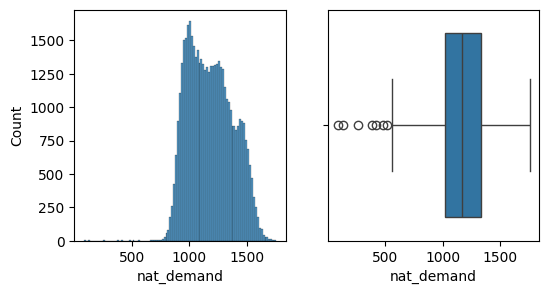

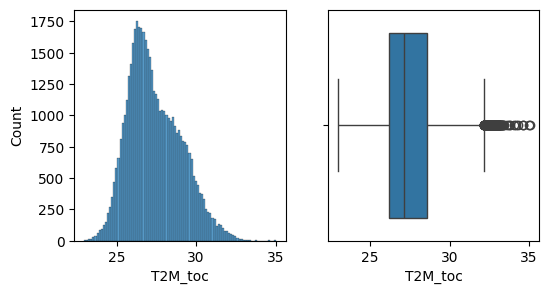

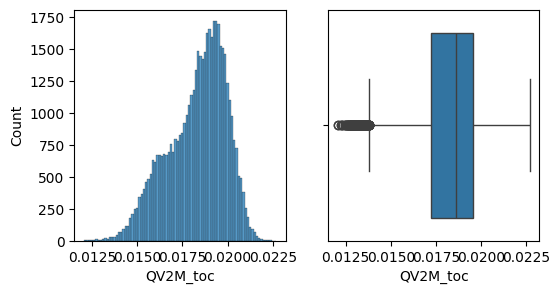

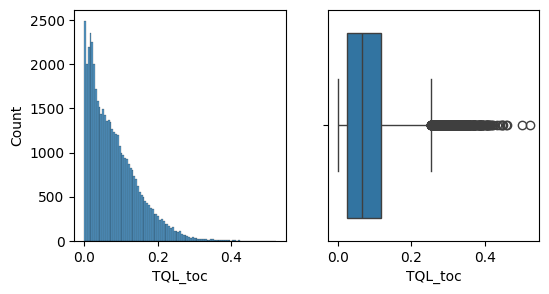

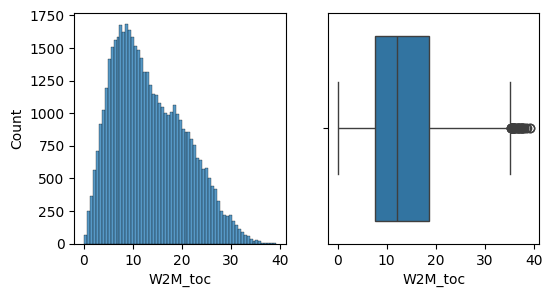

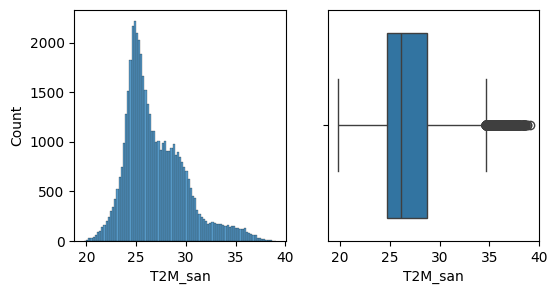

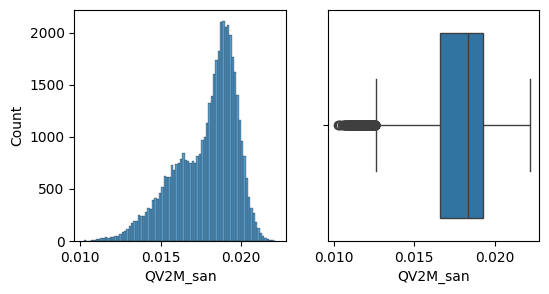

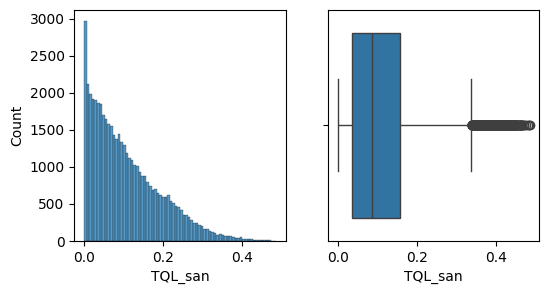

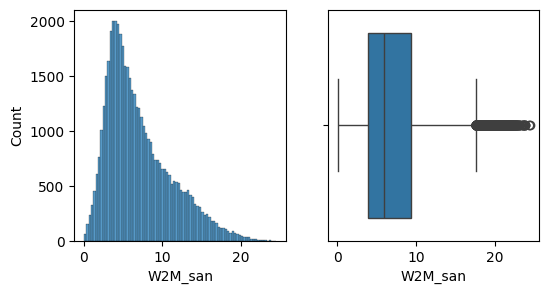

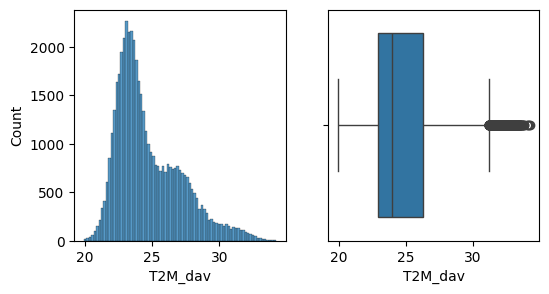

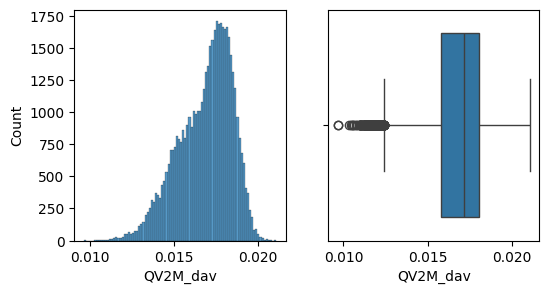

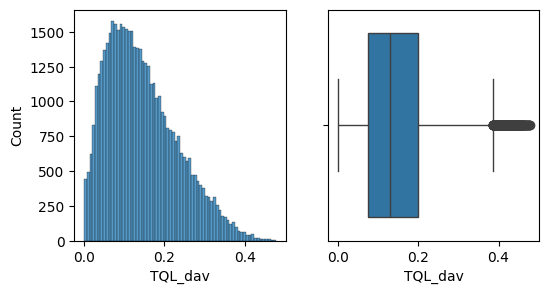

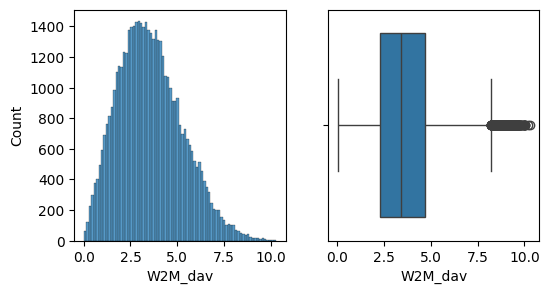

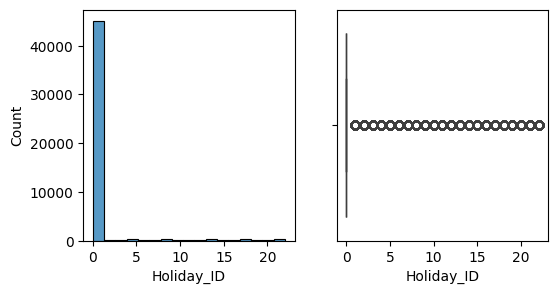

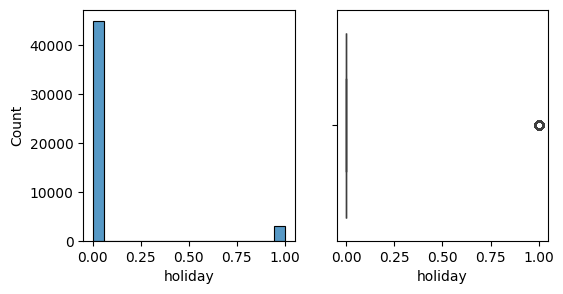

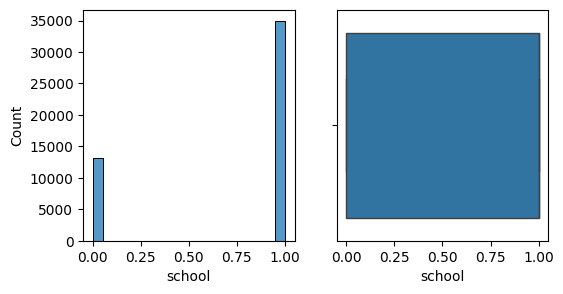

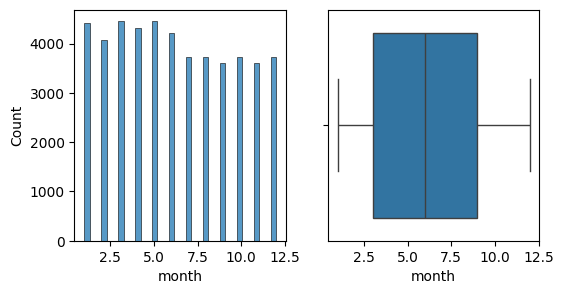

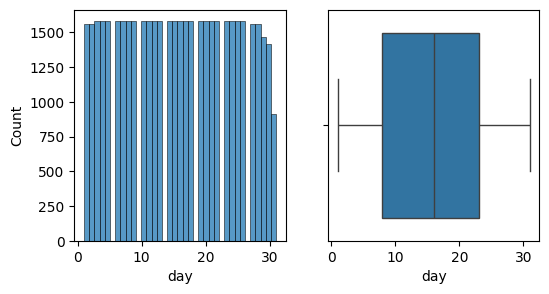

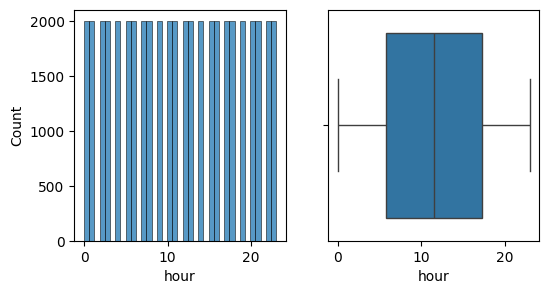

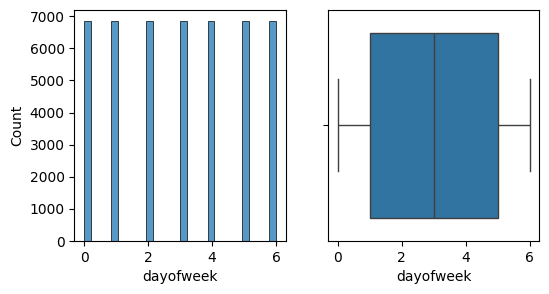

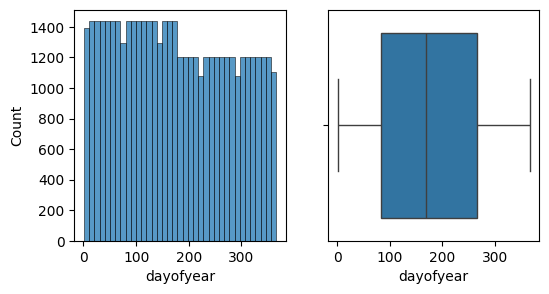

In [9]:
#lets look at the histograms of numeric columns to better understand the distributions
for col in df.select_dtypes(include = "number").columns:
  hist_and_boxplot(df,col)

Here we can observe that initial numeric columns are all skewed either right or left.

## Nat Demand

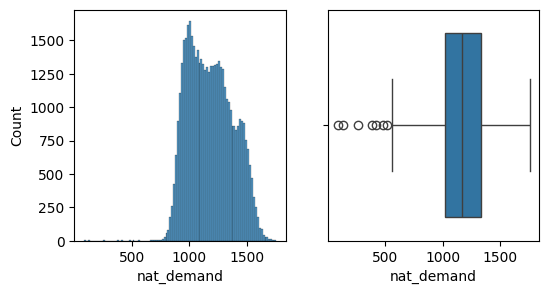

In [10]:
#Lets dive into nat demand column
hist_and_boxplot(df,"nat_demand")

I observe some outliers and want to look at them

In [11]:
df[df["nat_demand"] <500]

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,day,hour,dayofweek,dayofyear
21755,2017-06-27 12:00:00,380.5936,28.446252,0.017640,0.113861,5.408851,27.977502,0.019158,0.256470,5.553203,26.618127,0.017243,0.255127,3.294285,0,0,1,6,27,12,1,178
35483,2019-01-20 12:00:00,85.1925,29.394678,0.016237,0.033951,24.225527,29.144678,0.016504,0.202942,12.431692,29.144678,0.014662,0.050812,1.413640,0,0,0,1,20,12,6,20
35484,2019-01-20 13:00:00,135.7636,29.294672,0.016032,0.062653,24.641796,29.372797,0.016513,0.125244,14.316523,29.435297,0.014899,0.084290,1.615353,0,0,0,1,20,13,6,20
35485,2019-01-20 14:00:00,263.6183,28.969019,0.015850,0.067841,25.936263,29.547144,0.016460,0.057800,15.979043,29.187769,0.014873,0.114075,1.949015,0,0,0,1,20,14,6,20
35486,2019-01-20 15:00:00,417.4492,28.403619,0.015743,0.046555,27.945601,29.544244,0.016437,0.035233,16.643166,28.419244,0.014809,0.118805,2.599067,0,0,0,1,20,15,6,20
35487,2019-01-20 16:00:00,475.8024,27.655542,0.015736,0.025024,29.566897,28.780542,0.016301,0.044052,15.792458,27.405542,0.014706,0.113037,3.379718,0,0,0,1,20,16,6,20


Since I am not a subject matter expert I wont touch these points but 85 for example is pretty away from the first quantile. Hence there may be some problems regarding the dataset but since the number of these points is only 6 lets continue.

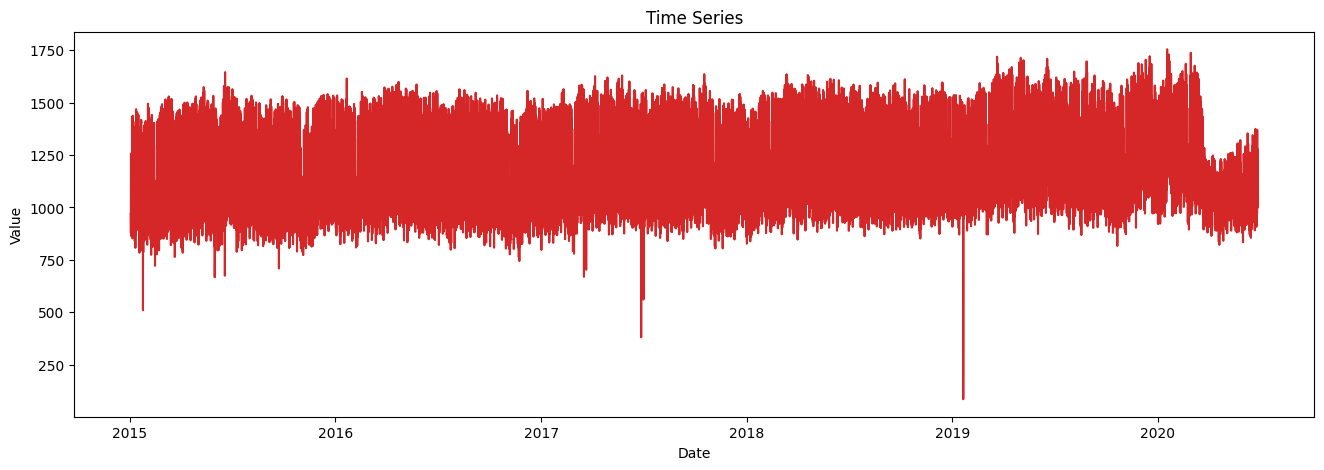

In [12]:
#Lets visualize the time series
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df["datetime"], y=df['nat_demand'], title='Time Series')

Here we can see that the data is from 2015 to 2020 which is the year of pandemic. Since the pandemic highly affected the electricity usage I will only look at till the start of pandemic which is late 2019.

In [13]:
df = df[df["datetime"] < "2019-12-31"]

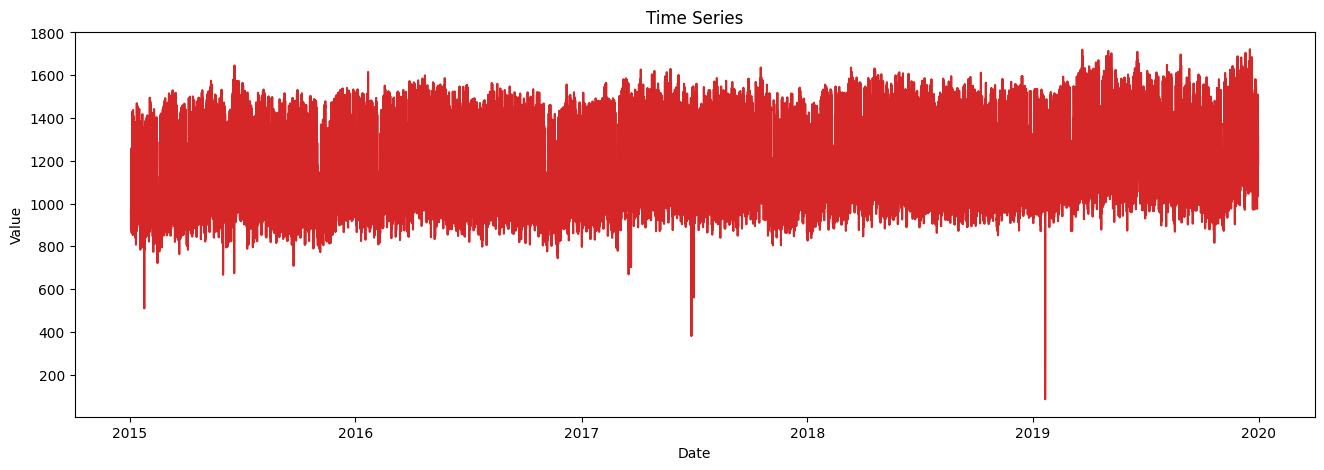

In [14]:
plot_df(df, x=df["datetime"], y=df['nat_demand'], title='Time Series')

Now we have a much stabil visual although there are some immediate low values. For consistency I will change these values with the mean

In [15]:
df.loc[df["nat_demand"] <500,"nat_demand"] = df["nat_demand"].mean()

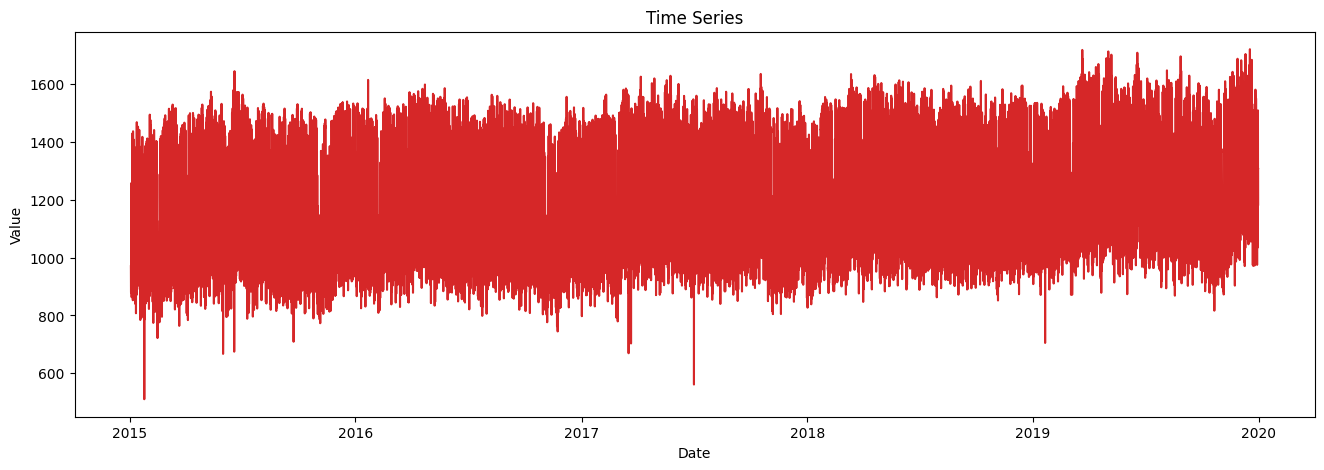

In [16]:
plot_df(df, x=df["datetime"], y=df['nat_demand'], title='Time Series')

We have a much better and reasonable plot now. Since it is hourly, hard to catch trends and seasoanility. Hence lets decompose it and try to see these effects.

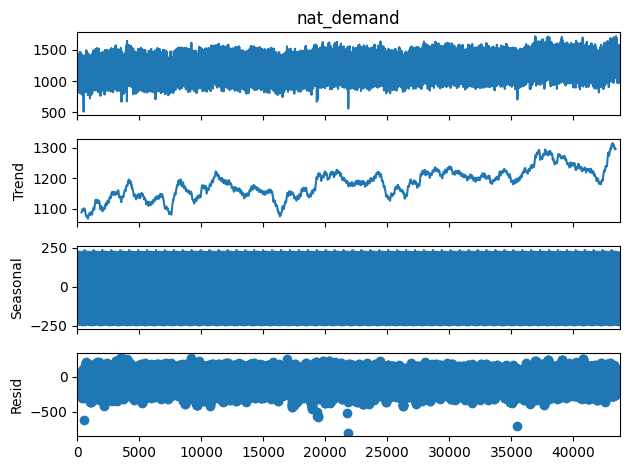

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_add = seasonal_decompose(df["nat_demand"], period = 24*30)
decomp_add.plot();

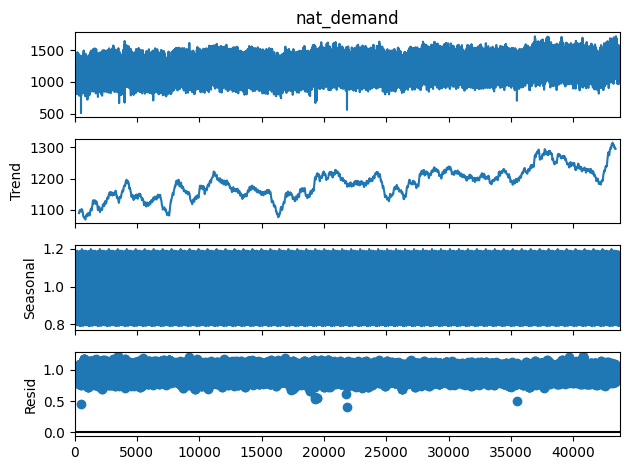

In [18]:
decomp_mul = seasonal_decompose(df["nat_demand"], period = 24*30, model = "multiplicative")
decomp_mul.plot();

I want to check the stationary with a statistical test.

In [19]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df["nat_demand"])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -21.252725
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    43695.000000
dtype: float64


Since p value is less than 0. We reject the null hypothesis that the nat demand is stationary.

<Axes: xlabel='hour', ylabel='nat_demand'>

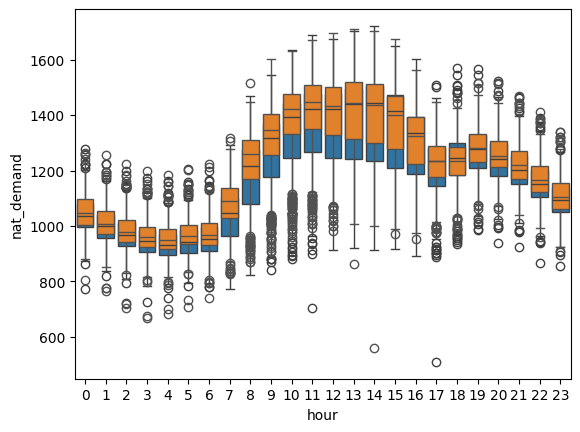

In [20]:
#Lets also look by season
energy_con_winter = df[df["month"].isin([12,1,2])]
energy_con_summer = df[df["month"].isin([6,7,8])]
sns.boxplot(data = energy_con_winter, x = "hour", y = "nat_demand")
sns.boxplot(data = energy_con_summer, x = "hour", y = "nat_demand")

Here the orange boxplots represent the usage in winter. As we can see, the usage in winter is higher than summer. Hence we conclude there is seasonality. Lets also look at daily and hourly.

<Axes: xlabel='dayofweek', ylabel='nat_demand'>

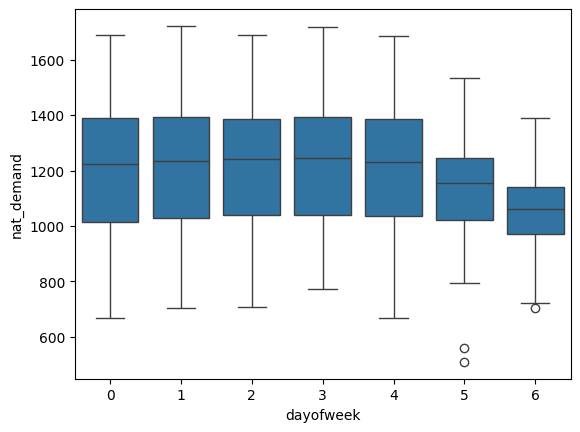

In [21]:
#daily
sns.boxplot(data = df, x = "dayofweek", y = "nat_demand")

We can see that weekdays are higher in the usage of electricity.

<Axes: xlabel='hour', ylabel='nat_demand'>

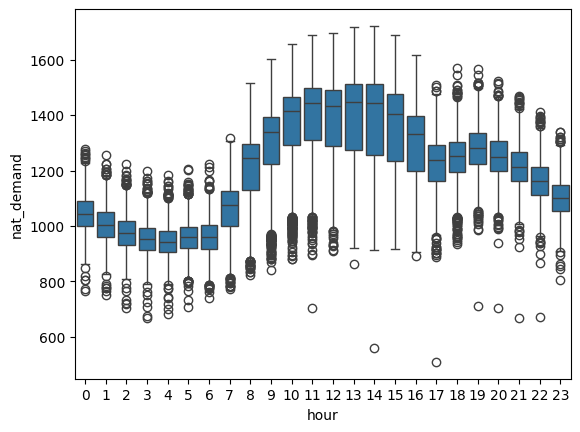

In [22]:
#hourly
sns.boxplot(data = df, x = "hour", y = "nat_demand")

Hourly effect can be seen easily, at night there is little and peek at 11-12 mid-day and again decrease till the night.

## Detrend Nat Demand

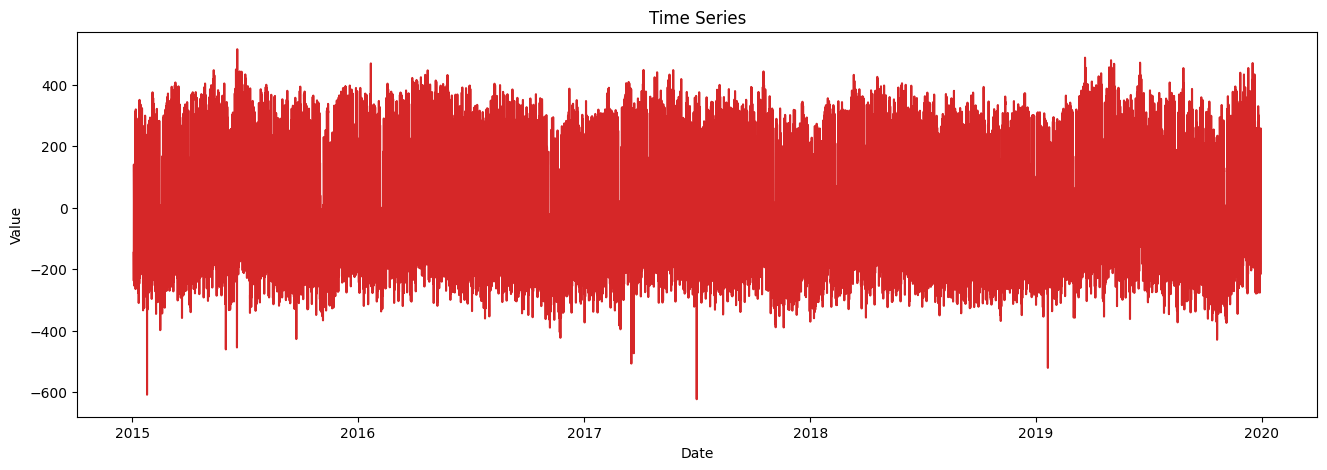

In [23]:
from scipy import signal
detrended = signal.detrend(df["nat_demand"])
plot_df(df, x=df["datetime"], y=detrended, title='Time Series')

After detrendin the data we see that the y range is now from -600 to 600. This suggests thet the original trend component had significant variability and contributing the positive nature of the data.

## Autocorrelation and Partial Autocorrelation Functions

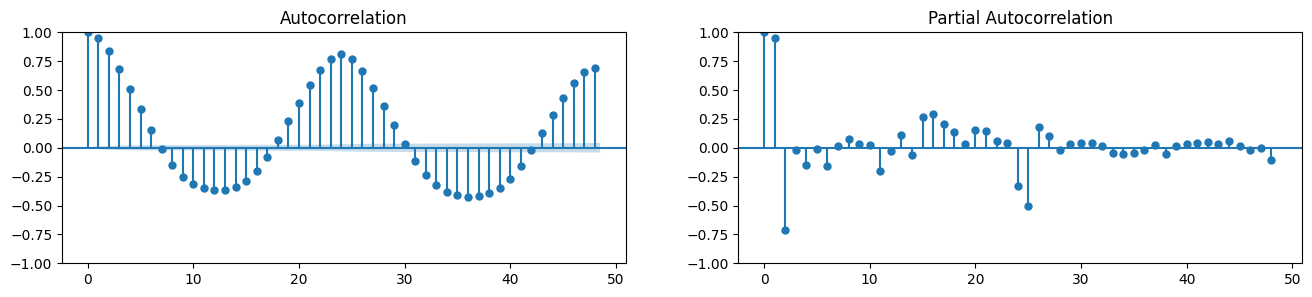

In [24]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df["nat_demand"], lags=48, ax=axes[0])
plot_pacf(df["nat_demand"], lags=48, ax=axes[1])
plt.show()

## ACF Interpretation
* Strong Seasonal Pattern: The ACF plot exhibits a strong cyclical pattern, indicating a significant seasonal component in the data. The periodic peaks and troughs suggest a consistent repeating pattern over time.
* Gradual Decay: The gradual decay in the ACF values also suggests that the series is not purely white noise and contains structure that persists over multiple lags.

## PACV Interpretation
* Sharp Cut-off: The PACF plot shows a sharp cut-off after a few lags, which typically indicates that the series can be modeled using an autoregressive (AR) process.
* First Lag Significant: The first lag is significantly high, which suggests that the immediate past value has a strong influence on the current value. This is indicative of an AR(1) process.
* Seasonal Lags: The periodic significant spikes in the PACF plot indicate that there is a seasonal component affecting the time series.

## Overall
We have a good seasonal effect. Hence I will use seasonal models like SARIMA or ETS

# Modelling

In [25]:
df_ts = df[["nat_demand","datetime"]]

In [26]:
# Lets split the data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_ts, test_size = 0.2, shuffle = False)

In [27]:
#Since we did not shuffle, the split is okey. Train data is will 2018-12-31 08.00 and rest is test
print(train["datetime"].min(), train["datetime"].max())
print(test["datetime"].min(), test["datetime"].max())

2015-01-03 01:00:00 2018-12-31 08:00:00
2018-12-31 09:00:00 2019-12-30 23:00:00


## Exponential Smoothing

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [30]:
model_1 = ExponentialSmoothing(train["nat_demand"], trend = "add", seasonal = "add", seasonal_periods = 24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [31]:
test_pred = model_1.forecast(len(test))

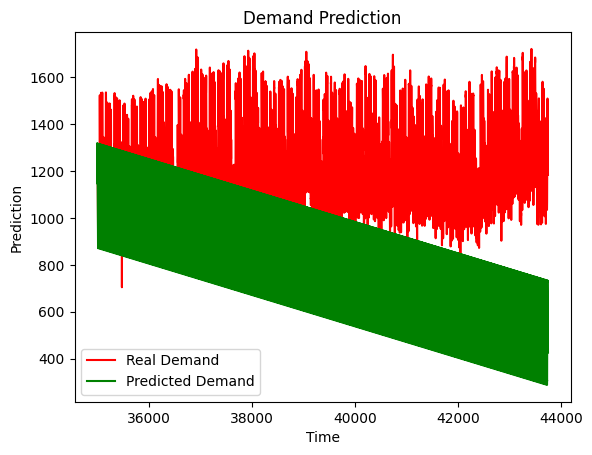

In [32]:
#lets visualize
plot_predictions(test["nat_demand"],test_pred)

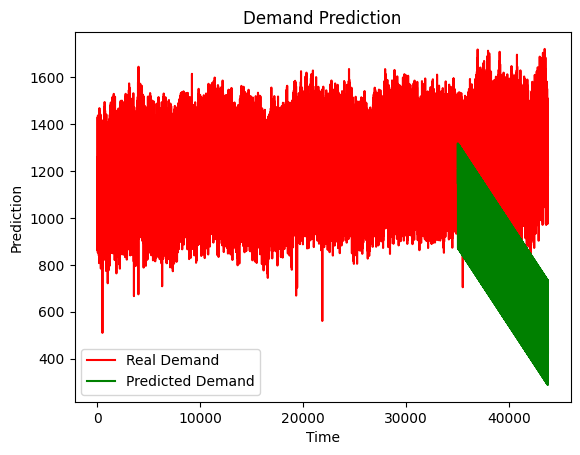

In [33]:
#lets comcetanete with the train and replot
y_true = pd.concat([train["nat_demand"],test["nat_demand"]])
y_pred = pd.concat([ pd.Series(test_pred, index = test.index)])
plot_predictions(y_true,y_pred)

In [35]:
#Lets get the inital rmse and mape
import math
from sklearn.metrics import mean_squared_error
rmse_ets = return_rmse(test["nat_demand"],y_pred)
mape_ets = np.mean(np.abs(test["nat_demand"] - y_pred)/test["nat_demand"])*100
print("MAPE: ", mape_ets)

The root mean squared error is 475.4643329840546.
MAPE:  34.84617888622146


Initial RMSE is 475 and MAPE is 34%, these values are not well performing.

Exponential smoothing fails the prediction since it is highly affected by the downward affect. But we can solve this issue with parameter tuning.

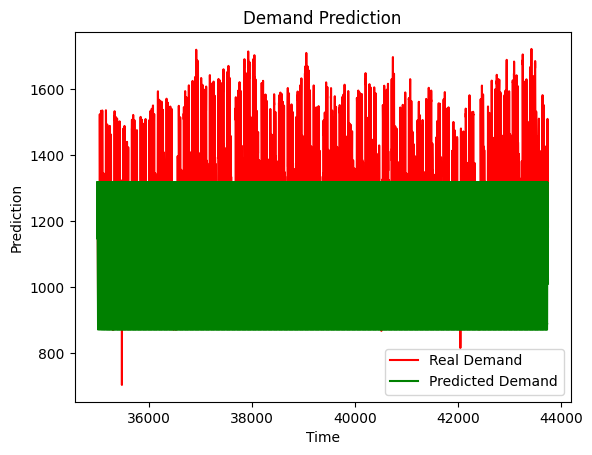

In [36]:
model = ExponentialSmoothing(train["nat_demand"], trend = "add", seasonal = "add", seasonal_periods = 24, damped_trend = True).fit()
test_pred = model.forecast(len(test))
plot_predictions(test["nat_demand"],test_pred)

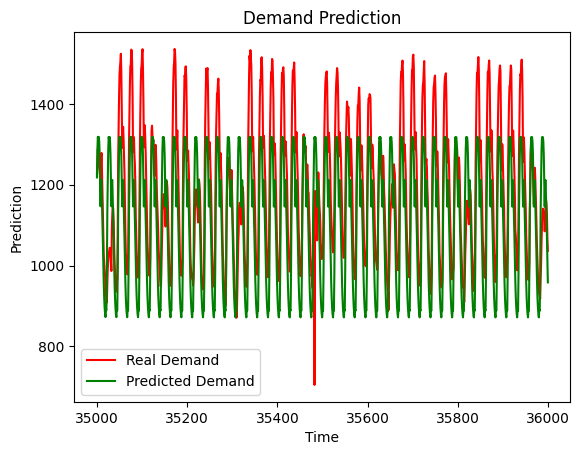

In [37]:
#lets zoom a bit
plot_predictions(test["nat_demand"][:1000],test_pred[:1000])

With additive trend and seasonality we got rid of the constant decrease rather got a more constant prediction. Still not behaving like true values. Lets calculat the RMSE and move on to next model.

In [38]:
rmse_ets_2 = return_rmse(test["nat_demand"],test_pred)
mape_ets_2 = np.mean(np.abs(test["nat_demand"] - test_pred)/test["nat_demand"])*100
print("MAPE: ", mape_ets)

The root mean squared error is 173.0434523963896.
MAPE:  34.84617888622146


Mean absolute percentage error with 12% means that the prediction lifts from the true value by 12%. From the initial model, by only adding damped trend parameter, we got pretty better in terms of accuracy.

Lets now do a neat parameter tuning.

In [39]:
from itertools import product
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [40]:
param_grid = {"trend":["add","mul"],"seasonal":["add","mul"],"damped_trend":[True,False],"seasonal_periods":[24,72]}
#

all_params = [v for v in param_grid.values()]
param_product = list(product(*all_params))
best_param_ets = None
best_rmse_ets = float("inf")
for param in param_product:
    best_param_ets = param
    model = ExponentialSmoothing(train["nat_demand"], trend = param[0], seasonal = param[1], seasonal_periods = param[3], damped_trend = param[2]).fit()
    test_pred = model.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test["nat_demand"],
                                      test_pred))
    mape = np.mean(np.abs(test["nat_demand"] - test_pred)/test["nat_demand"])*100
    if rmse < best_rmse_ets:
        best_rmse_ets = rmse
        best_param_ets = param
        best_mape_ets = mape
print(best_param_ets, best_rmse_ets)

('mul', 'mul', False, 72) 127.7099610585641


Best parameters occurs to be with both multiplicative components and 3 day periods. With RMSE:127 better than the above model with RMSE:173. Hence we are improving.

## ARIMA Model

**ARIMA Model Summary**

Purpose: Forecast future points in a time series by capturing dependencies among observations.

Components:

* AR (AutoRegressive): Uses past values to predict current values, denoted by p.
* I (Integrated): Differencing to make the series stationary, denoted by d.
* MA (Moving Average): Uses past forecast errors to predict current values, denoted by q.
* Key: The ARIMA model is specified as ARIMA(p, d, q), where:

* p: Number of lag observations.
* d: Number of times the series is differenced.
* q: Number of lagged forecast errors.

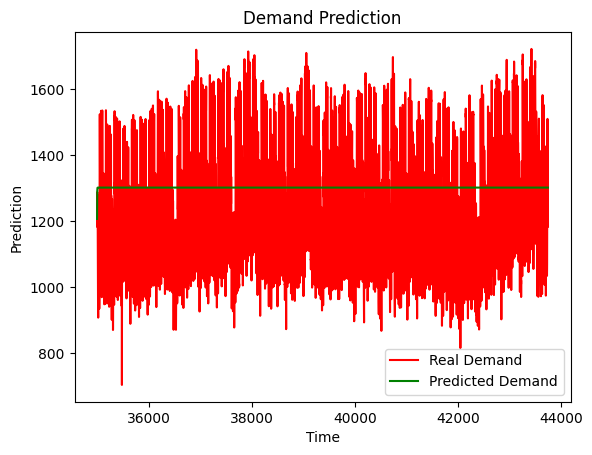

                               SARIMAX Results                                
Dep. Variable:             nat_demand   No. Observations:                35000
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -182575.882
Date:                Tue, 06 Aug 2024   AIC                         365157.765
Time:                        19:57:57   BIC                         365183.154
Sample:                             0   HQIC                        365165.852
                              - 35000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5580      0.005    103.418      0.000       0.547       0.569
ma.L1          0.2061      0.005     40.186      0.000       0.196       0.216
sigma2      1991.5114      6.608    301.391      0.0

In [41]:
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(train["nat_demand"], order = (1,1,1))
model_arima = model_arima.fit()
plot_predictions(test["nat_demand"],model_arima.forecast(len(test)))
print(model_arima.summary())
print("RMSE:",np.sqrt(mean_squared_error(test["nat_demand"],model_arima.forecast(len(test)))))

Initial score is 196 which is worse than the last two models. Hence we continue with parameter optimization.

In [42]:
#Lets tune the parameters
param_grid = {"p":[0,1,2],"d":[0,1,2],"q":[0,1,2]}
params = [v for v in param_grid.values()]
param_product = list(product(*params))
best_param_arima = None
best_rmse_arima = float("inf")
best_mape_arima = float("inf")
for param in param_product:
    model_arima = ARIMA(train["nat_demand"], order = (param[0],param[1],param[2]))
    model_arima = model_arima.fit()
    test_pred = model_arima.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test["nat_demand"],test_pred))
    mape = np.mean(np.abs(test["nat_demand"] - test_pred)/test["nat_demand"])*100
    if rmse < best_rmse_arima:
        best_rmse_arima = rmse
        best_mape_arima = mape
        best_param_arima = param
print(best_param_arima, best_rmse_arima)

(0, 1, 2) 191.544062437951


The best result came out as RMSE: 191. The reason is probably the lack of parameters. I could not add more parameters since the RAM resource and time efficiency is more important at instance. Lets move on SARIMA model with seasonality effect added to ARIMA model.

## SARIMA Model

**SARIMA Model Summary**

Purpose: Extend ARIMA for seasonal time series forecasting by incorporating seasonal elements.

Components:

* AR (AutoRegressive): Uses past values to predict current values, denoted by p.
* I (Integrated): Differencing to make the series stationary, denoted by d.
* MA (Moving Average): Uses past forecast errors to predict current values, denoted by q.

Seasonal Components:
* Seasonal AR (P): Seasonal autoregressive terms.
* Seasonal I (D): Seasonal differencing.
* Seasonal MA (Q): Seasonal moving average terms.
* Seasonal Period (m): Number of observations per season.
* Key: The SARIMA model is specified as ARIMA(p, d, q)(P, D, Q)m, where:

* p, d, q: Regular terms.
* P, D, Q: Seasonal terms.
* m: Seasonal period.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(train["nat_demand"], order = (1,1,1), seasonal_order = (1,1,1,24))
model_sarimax = model_sarimax.fit()
plot_predictions(test["nat_demand"],model_sarimax.forecast(len(test)))
print(model_sarimax.summary())
print("RMSE:",np.sqrt(mean_squared_error(test["nat_demand"],model_sarimax.forecast(len(test)))))

I tried to fit SARIMA model but RAM exploded. Since other grid searches takes too much time, I will not risk it again and directly moving to GRU model.
UPDATE: I tried again, still crashing :(

In [ ]:
param_grid = {"p":[0,1,2],"d":[0,1],"q":[0,1],"P":[0,1,4]}
params = [v for v in param_grid.values()]
param_product = list(product(*params))
best_param_sarima = None
best_rmse_sarima = float("inf")
best_mape_sarima = float("inf")
for param in param_product:
  best_param_sarima = param
  model_sarimax = SARIMAX(train["nat_demand"], order = (param[0],param[1],param[2]), seasonal_order = (param[3],0,0,24))
  model_sarimax = model_sarimax.fit()
  test_pred = model_sarimax.forecast(len(test))
  rmse = np.sqrt(mean_squared_error(test["nat_demand"],test_pred))
  mape = np.mean(np.abs(test["nat_demand"] - test_pred)/test["nat_demand"])*100
  if rmse < best_rmse_sarima:
    best_rmse_sarima = rmse
    best_mape_sarima = mape
    best_param_sarima = param
print(best_param_sarima, best_rmse_sarima)

## GRU

**GRU Model Summary**

Purpose: GRU (Gated Recurrent Unit) models sequential data and captures long-term dependencies.

Key Features:

Gates:

* Reset Gate: Decides how much past information to forget.
* Update Gate: Balances past and present information.
* Simpler than LSTM: Fewer parameters, leading to faster training.

Advantages:

* Efficient Training: Faster and less resource-intensive.
* Effective for Sequential Data: Ideal for time series forecasting, speech recognition, etc.
* Structure: Combines hidden state and cell state into one.

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,GRU,Dropout
from sklearn.preprocessing import MinMaxScaler

In [29]:
model = Sequential()
model.add(GRU(units = 50, return_sequences = True, input_shape = (train.shape[1],1)))
model.add(GRU(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 2, 50)               │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train["nat_demand"].values.reshape(-1,1))
test_scaled = scaler.transform(test["nat_demand"].values.reshape(-1,1))

#look at the past 60 days
X_train = []
y_train = []
for i in range(60,train_scaled.shape[0]):
  X_train.append(train_scaled[i-60:i,0])
  y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

By looking at the pas 60 days, predict next value. Hence the data leakage is deterred.

In [31]:
model.fit(X_train, y_train, epochs = 50, batch_size = 32, shuffle = False)

Epoch 1/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0133
Epoch 2/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0029
Epoch 3/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0024
Epoch 4/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0019
Epoch 5/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0016
Epoch 6/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0013
Epoch 7/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0012
Epoch 8/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0012
Epoch 9/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0011
Epoch 10/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 9.6163e-04
Epoch 11/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 8.6366e-04
Epoch 12/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 8.4628e-04
Epoch 13/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 7.7839e-04
Epoch 14/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7.4619e-

In [32]:
X_test = []
for i in range(60,test_scaled.shape[0]):
  X_test.append(test_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
x_pred = model.predict(X_test)
x_pred = scaler.inverse_transform(x_pred)

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [38]:
from sklearn.metrics import mean_squared_error
print("RMSE:",np.sqrt(mean_squared_error(test["nat_demand"][60:],x_pred)))
gru_rmse = np.sqrt(mean_squared_error(test["nat_demand"][60:],x_pred))

RMSE: 24.075292805051543


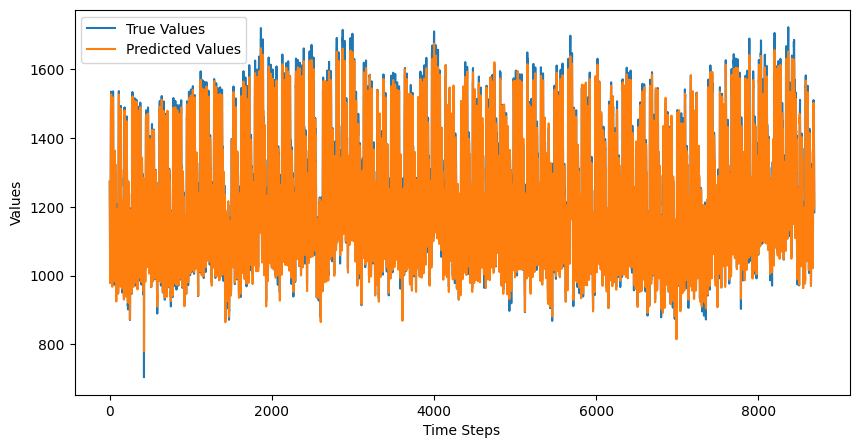

In [42]:
#Lets plot
time_steps = np.arange(0,len(test["nat_demand"][60:]))
y_true = test["nat_demand"][60:]
y_pred = x_pred
plt.figure(figsize = (10,5))
plt.plot(time_steps, y_true, label = "True Values")
plt.plot(time_steps, y_pred, label = "Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.show()

# Model Comparison

In [7]:
models = ["Exponential Smoothing","ARIMA","GRU"]
rmse = [173.45, 191, 24]

<Axes: title={'center': 'Model Comparison'}, xlabel='Models', ylabel='RMSE'>

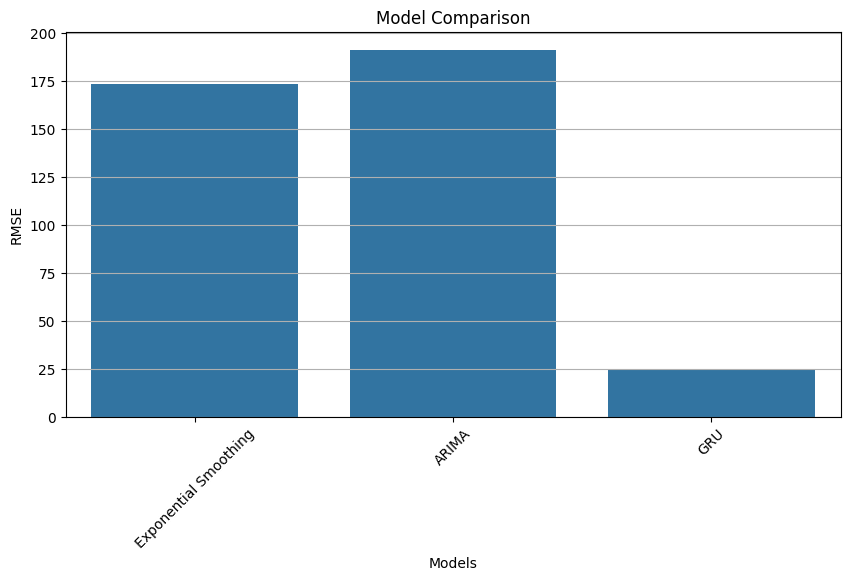

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
model_df = pd.DataFrame({"Models":models,"RMSE":rmse})
plt.figure(figsize = (10,5))
plt.title("Model Comparison")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.grid()
plt.xticks(rotation = 45)
sns.barplot(data = model_df, x = "Models", y = "RMSE")

## Why GRU Model Outperformed ETS, ARIMA, and SARIMAX
* Handling Non-Linearities: GRUs can capture complex, non-linear patterns in the data, which traditional methods like ETS, ARIMA, and SARIMAX might miss.

* Long-Term Dependencies: GRUs effectively model long-term dependencies in sequential data, a strength over the more linear approaches of ETS and ARIMA.

* Adaptive Learning: GRUs adapt to varying patterns in the data through their gating mechanisms, providing more accurate forecasts compared to the fixed structures of ETS and SARIMAX.

* Efficiency: With fewer parameters and faster training compared to SARIMAX (which can be computationally intensive), GRUs offer both efficiency and performance.

* Robustness: GRUs generally perform better in capturing intricate temporal dynamics, leading to improved prediction accuracy over traditional statistical methods.